In [ ]:
pip install -U git+https://github.com/MIROptics/ECC2025.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.primitives import Estimator
from ECC2025.testing import test_2a, test_2b, test_2c

Los computadores cuánticos han mejorado mucho los últimos años, siendo capaces de ejecutar algoritmos cuánticos en número de qubits moderados. Sin embargo, no es posible resolver problemas practicos con ellos debido a que son ruidosos.

Para reducir el impacto de estos errores se han propuestos varios metodos de mitigación de errores, siendo el más conocido [__Zero-Noise Extrapolation (ZNE)__](https://arxiv.org/abs/1612.02058). Este método se basa en aumentar intensionalmente el ruido en el circuito aumentando su profundidad, para posteriormente extrapolar el limite sin ruido.

Consideremos que queremos evaluar un observable $A$ sobre un estado $|\psi\rangle=U_mU_{m-1}\cdots U_1|0\rangle$, donde $\{U_j\}$ es una secuencia de puertas cuánticas ruidosas. Llamaremos $U=U_mU_{m-1}\cdots U_1$ a la operación del circuito completo. ZNE se basa en obtener varias estimaciones de $\langle A \rangle$ con distintos ruidos realizando [__pliegues__](https://arxiv.org/abs/2005.10921) de la unitaria $U$. Un pliege corresponde a la transformación $U\rightarrow UU^\dagger U$.

![](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/img/ECC25_ZNE.png)

Estos circuitos son equivalentes para estimar el valor esperado de $A$ gracias a que las puerta cuántica $U$ satisfacen $U^\dagger U=I$. Sin embargo, debido a que al plegar un circuito su profundidad aumenta, la cantidad de error también aumenta. 

__Desafio:__ Escriba una función que tenga por argumento un circuito cuántico ```qc_U``` con la operación $U$ de un número arbitario de qubits, y que construya el circuito equivalente ```qc_U_N``` con $N$ pliegues.

In [3]:
def folding( qc_U, N ):

    qc_U_N = qc_U.copy()

    ##### Escriba su solución acá #####

    ########################
    
    return qc_U_N

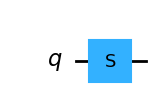

In [4]:
qc_U = random_circuit(1,1)
qc_U.draw('mpl')

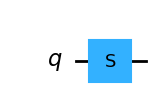

In [5]:
N = 2
qc_U_N = folding( qc_U, N )
qc_U_N.draw('mpl') 

In [ ]:
test_2a( folding )

__Desafio:__ Consideremos el siguiente observable de 2 qubits,
$$ A = \sigma_x\otimes \sigma_y + 2\sigma_y\otimes\sigma_x + 3\sigma_z\otimes\sigma_x. $$
Construya este observable utlizando la función ``SparsePauliOp``.

In [7]:
A = SparsePauliOp(['II'], [1]) # Esto es solo una opción por defecto

### Escriba su respuesta aca

####

A

SparsePauliOp(['II'],
              coeffs=[1.+0.j])

In [ ]:
test_2b( A )

Las siguientes celdas realizan  una simulación con ruido de la evaluación de $A$. El gráfico muestra el resultado para un caso donde $\langle A \rangle = -3$. Podemos como el valor esperado de la simulación ruidosa se va alejando del valor ideal a medida que aumentan los pliegues.

In [9]:
noise_model = NoiseModel()
error = depolarizing_error( 0.01, 1 )
noise_model.add_quantum_error( error, ['x', 'h', 'u', 'y', 'z'], [0] )
noise_model.add_quantum_error( error, ['x', 'h', 'u', 'y', 'z'], [1] )

backend = Estimator( backend_options={'noise_model':noise_model},
                    run_options={'shots':1000, 'seed':0 },
                    skip_transpilation = True ) 

In [10]:
def simulacion( qc_U, Ns ):
    obs = []
    for n in Ns:
        qc_U_N = folding( qc_U, n )
        job = backend.run( qc_U_N.decompose(reps=3), A )
        obs.append( job.result().values[0] )
    return obs 

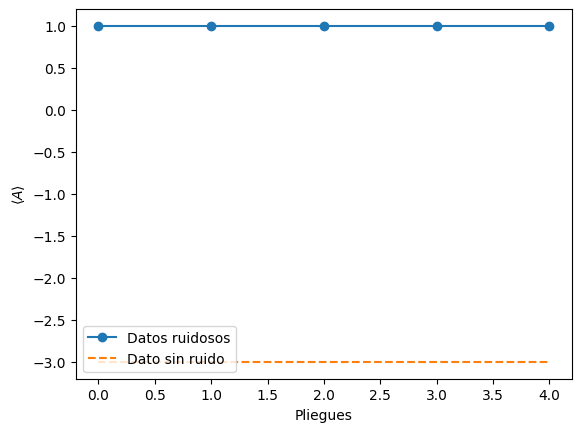

In [11]:
qc_U = QuantumCircuit(2)
qc_U.h(0)
qc_U.cx(0,1)
qc_U.sdg(1)
Ns = [ 0, 1, 2, 3, 4 ]
obs = np.mean([ simulacion( qc_U, Ns ) for _ in range(10) ], axis=0)
plt.plot( Ns, obs, '-o' ) 
plt.hlines( -3, 0, 4, linestyles='--', color='tab:orange' )
plt.xlabel('Pliegues')
plt.ylabel(r'$\langle A \rangle$')
plt.legend(['Datos ruidosos', 'Dato sin ruido'])

Gracias a esto se puede realizar un extrapolación y obtener un estimador de $\langle A\rangle$ "sin ruido". La extrapolación más simple es la lineal, la cual toma estimadores ruidosos $\{ \langle A_N\rangle \}$ de circuitos con $N$ pliegues y supone que
$$ \langle A_N\rangle \approx a ( 2N+1) + b .$$ 
Luego, mediente interpolación por minimos cuadrados se encuentran los parametros $a$ y $b$. El estimador sin ruido es dado por
$$ \langle A\rangle \approx b .$$

![fit](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/img/fig_ZNE_fit.png?raw=true)

__Desafio:__ Complete la siguiente función que realiza el ajuste de los parametros $a$ y $b$. Puede ayudarse de funciones de otras librerias como ``numpy`` o ``scipy``.  

In [12]:
def extrapolation( Ns, obs ):

    a = 0
    b = 0

    #### Escriba su solución aca ######

    ###################################

    return a, b

Con la siguiente celda podemos ver como funciona nuestra extrapolación.

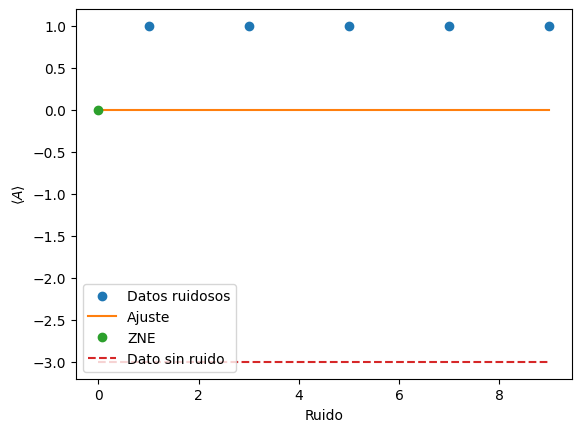

In [13]:
a, b = extrapolation( Ns, obs )
x = np.arange(0,np.max(2*np.array(Ns)+1)+1)
y = a * x + b 
plt.plot( 2*np.array(Ns)+1, obs, 'o' ) 
plt.plot( x, y )
plt.plot( [0], [b], 'o' )
plt.hlines( -3, 0, 9, linestyles='--', color='tab:red' )
plt.xlabel('Ruido')
plt.ylabel(r'$\langle A\rangle$')
plt.legend(['Datos ruidosos', 'Ajuste', 'ZNE','Dato sin ruido' ] )
# plt.savefig('fig_ZNE_fit.png')

In [ ]:
test_2c( extrapolation, A, Ns, folding )

El estudio e implementación de métodos de mitigación de errores es un campo activo de investigación. En particular, Qiskit ya tiene integradas varias técnicas de <a href='https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques'>mitigación y supresión de errores</a>. Más aún, existe una libreria exclusivamente dedicada a la mitigación de errores llamada <a href='https://mitiq.readthedocs.io/en/stable/index.html'>mitiq</a>. Esta libreria es no solo compatible con Qiskit, si no que también con otros lenguajes para controlar computadores cuánticos como Pennylane o Cirq.